In [1]:
import torch, torchtext
from torchtext.functional import to_tensor
from torchtext.transforms import SentencePieceTokenizer
xlmr_base = torchtext.models.XLMR_BASE_ENCODER
model = xlmr_base.get_model()
transform = xlmr_base.transform()
input_batch = ["Hello world", "How are you!"]
model_input = to_tensor(transform(input_batch), padding_value=1)
output = model(model_input)
output.shape

torch.Size([2, 6, 768])

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from models import TextClassificationModel, zip_ssl
from datasets import AGNEWS
from utils import train, eval, pearson, acc, nomean, pearson_delta

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
EPOCHS = 30
LR = 1e-3
BATCH_SIZE = 2048
EMBED_DIM = 64

In [5]:
ds = AGNEWS()

In [6]:
criterion = nn.MSELoss()
num_classes = 1
LR=1e-5

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
# from utils import train

# Initialize RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.to(device)

# Define the optimizer for the whole model (both RoBERTa and the classification head)
optimizer = optim.AdamW(list(roberta_model.parameters()), lr=LR)

# Function to get RoBERTa embeddings for a list of sentences
def model(sentences):
    # Tokenize the sentences
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the device

    # Get the embeddings (without using torch.no_grad())
    outputs = roberta_model(**inputs, output_hidden_states=True)
    del inputs
    torch.cuda.empty_cache()
    embeddings = outputs.hidden_states[-1]  # Last layer embeddings

    # Average the embeddings along the max_sequence_length dimension
    embeddings_avg = embeddings.mean(dim=1)

    return embeddings_avg

# Assuming you have defined the AGNEWS class and its methods correctly
ds = AGNEWS()
BATCH_SIZE = 16
train_loader, val_loader, test_loader = ds.loader(BATCH_SIZE, ssl=True)


/home/josegfer/miniconda3/envs/jiang2023low/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from torch.functional import F

def pearson(delta, ncd):
    vx = delta - torch.mean(delta)
    vy = ncd - torch.mean(ncd)

    return F.cosine_similarity(vx, vy, dim = 0)

In [62]:
def train(model, loader, criterion, optimizer, ssl = False):
    cost = 0
    corr = 0
    log = []
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(loader)):
        if ssl:
            btsz = len(offsets) // 2
            h = model(label)
            delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
            # print(idx, delta.mean())
            loss = criterion(delta, ncd)
        else:
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)

        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        log.append([loss.item(), pearson(delta, ncd).detach().cpu(), delta.mean().detach().cpu()])
        cost += loss.item()
        corr += pearson(delta, ncd).detach().cpu()
    return cost / loader.dataset.__len__(), corr / loader.__len__(), log

In [86]:
loss_train, corr_train, log = train(model, train_loader, criterion, optimizer, ssl = True)

7125it [14:46,  8.04it/s]


(1.4953795590324597e-05, tensor(0.9502))

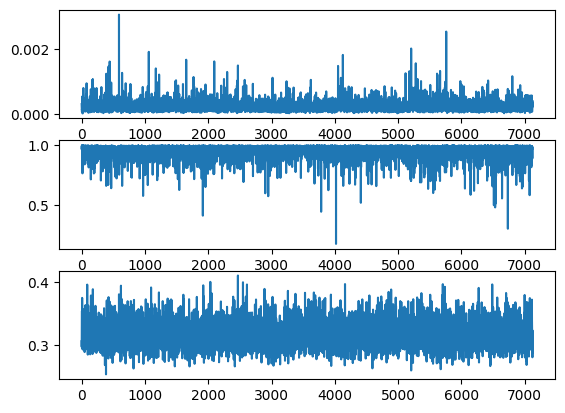

In [87]:
log = np.array(log)
fig, axes = plt.subplots(3)
axes[0].plot(log[:, 0]);
axes[1].plot(log[:, 1]);
axes[2].plot(log[:, 2]);
loss_train, corr_train

In [88]:
D_train = torch.empty(size = [0])
D_val = torch.empty(size = [0])
D_test = torch.empty(size = [0])

NCD_train = torch.empty(size = [0])
NCD_val = torch.empty(size = [0])
NCD_test = torch.empty(size = [0])

with torch.no_grad():
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(train_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_train = torch.cat((D_train, delta.cpu()))
        NCD_train = torch.cat((NCD_train, ncd.cpu()))

    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(val_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_val = torch.cat((D_val, delta.cpu()))
        NCD_val = torch.cat((NCD_val, ncd.cpu()))

    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(test_loader)):
        btsz = len(offsets) // 2
        h = model(label)
        delta = F.pairwise_distance(h[:btsz], h[btsz:]) / 10
        D_test = torch.cat((D_test, delta.cpu()))
        NCD_test = torch.cat((NCD_test, ncd.cpu()))

7125it [04:42, 25.23it/s]
375it [00:14, 26.27it/s]
475it [00:17, 26.62it/s]


(tensor(0.9524), tensor(0.9507), tensor(0.9453))

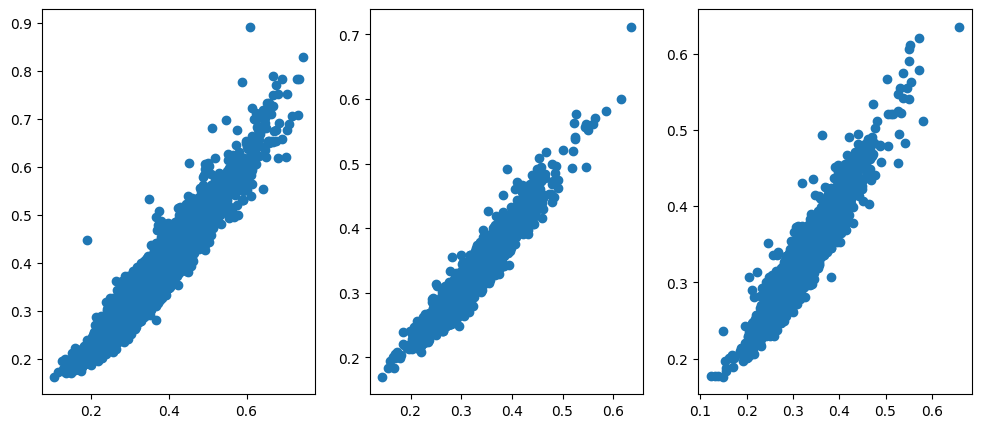

In [60]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

(tensor(0.9591), tensor(0.9566), tensor(0.9530))

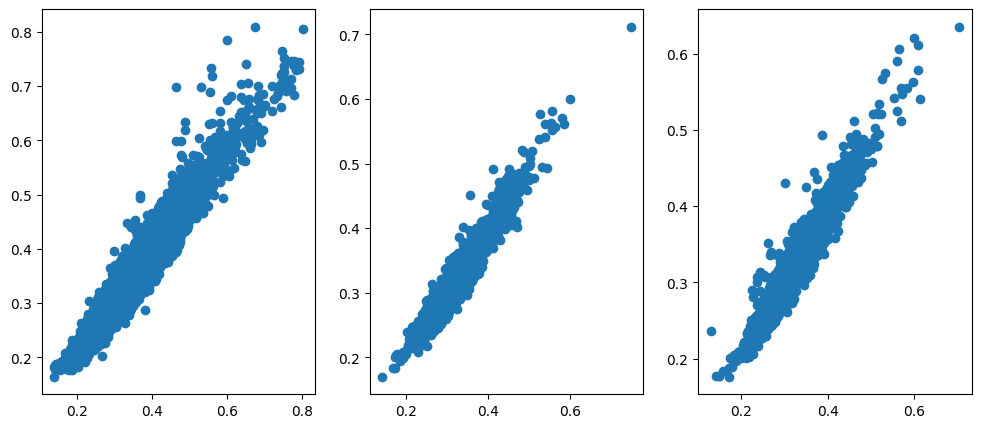

In [67]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

(tensor(0.9612), tensor(0.9580), tensor(0.9551))

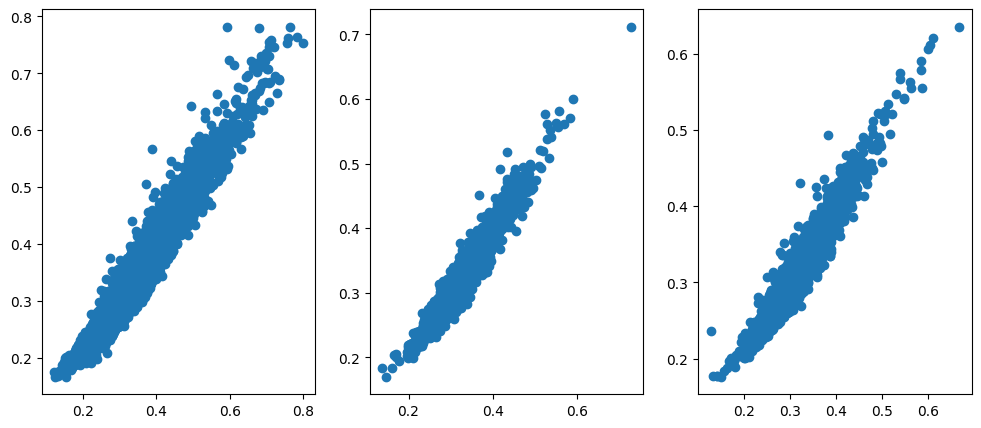

In [75]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

(tensor(0.9664), tensor(0.9617), tensor(0.9599))

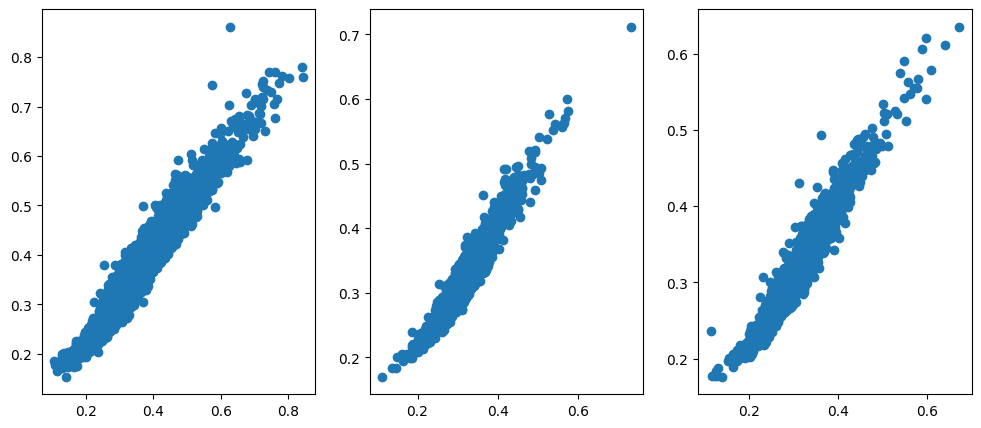

In [82]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

(tensor(0.9625), tensor(0.9570), tensor(0.9580))

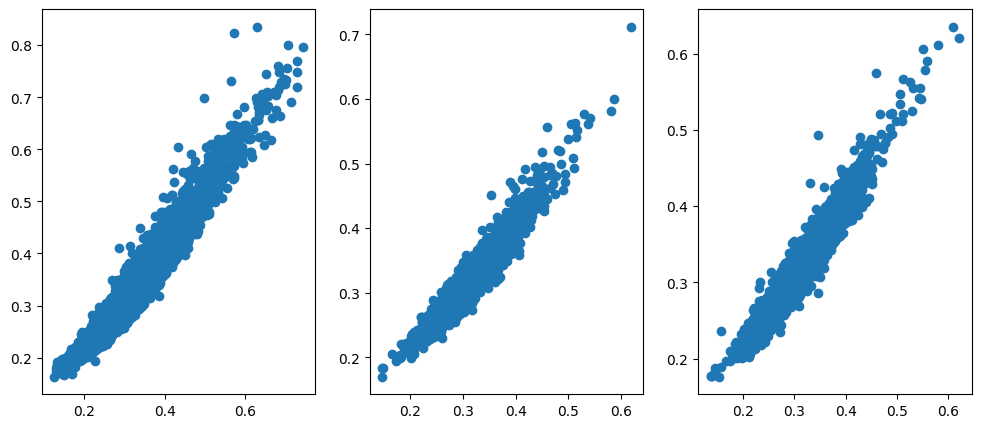

In [89]:
fig, axes = plt.subplots(1, 3, figsize = (12, 5))
axes[0].scatter(D_train, NCD_train);
axes[1].scatter(D_val, NCD_val);
axes[2].scatter(D_test, NCD_test);

pearson(D_train, NCD_train), pearson(D_val, NCD_val), pearson(D_test, NCD_test)

In [90]:
H_train = torch.empty(size = [0])
H_val = torch.empty(size = [0])
H_test = torch.empty(size = [0])

y_train = torch.empty(size = [0])
y_val = torch.empty(size = [0])
y_test = torch.empty(size = [0])

with torch.no_grad():
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(train_loader)):
        h = model(label)
        H_train = torch.cat((H_train, h.cpu()))
        y_train = torch.cat((y_train, classes.cpu()))
        
    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(val_loader)):
        h = model(label)
        H_val = torch.cat((H_val, h.cpu()))
        y_val = torch.cat((y_val, classes.cpu()))

    for idx, (label, text, offsets, classes, ncd) in tqdm(enumerate(test_loader)):
        h = model(label)
        H_test = torch.cat((H_test, h.cpu()))
        y_test = torch.cat((y_test, classes.cpu()))

7125it [07:04, 16.78it/s]
375it [00:13, 27.03it/s]
475it [00:17, 27.10it/s]


# clf

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [91]:
neigh = KNeighborsClassifier(n_neighbors = 2)
neigh.fit(H_train, y_train);

In [92]:
neigh.score(H_val, y_val), neigh.score(H_test, y_test)

(0.7048333333333333, 0.7030263157894737)